# TAA Project 1

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

### Process the data files

In [2]:
meta_path = 'dataset/Meta'
train_path = 'dataset/Train'
test_path = 'dataset/Test'

NUM_CATEGORIES = len(os.listdir(train_path))
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

### Distribution of images per signal on the Train set

Number of classes: 43


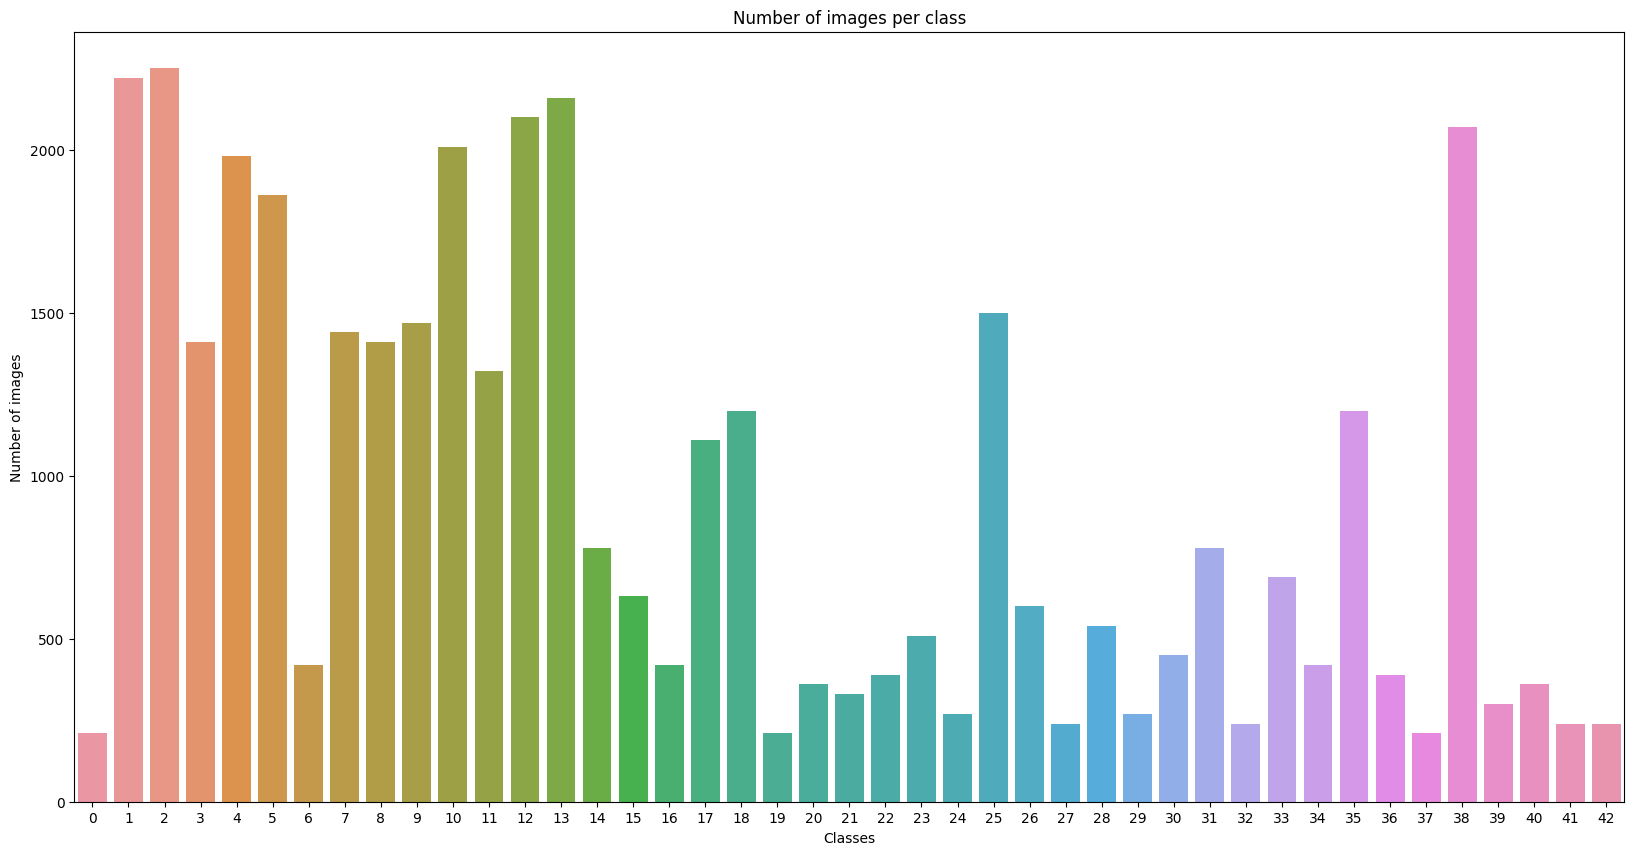

In [3]:
# Get the names of the classes
train = pd.read_csv('dataset/Train.csv')
meta = pd.read_csv('dataset/Meta.csv')
classes = meta['ClassId']
classes = np.array(classes)
classes = np.sort(classes)

print('Number of classes: {}'.format(len(classes)))

# Get the number of images per class
num_images = []
for c in classes:
    num_images.append(len(train[train['ClassId'] == c]))

# Plot the histogram
plt.figure(figsize=(20, 10))
sns.barplot(x=classes, y=num_images)
plt.title('Number of images per class')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.savefig('train_distribution.png')
plt.show()


### Subset of images from the Train set

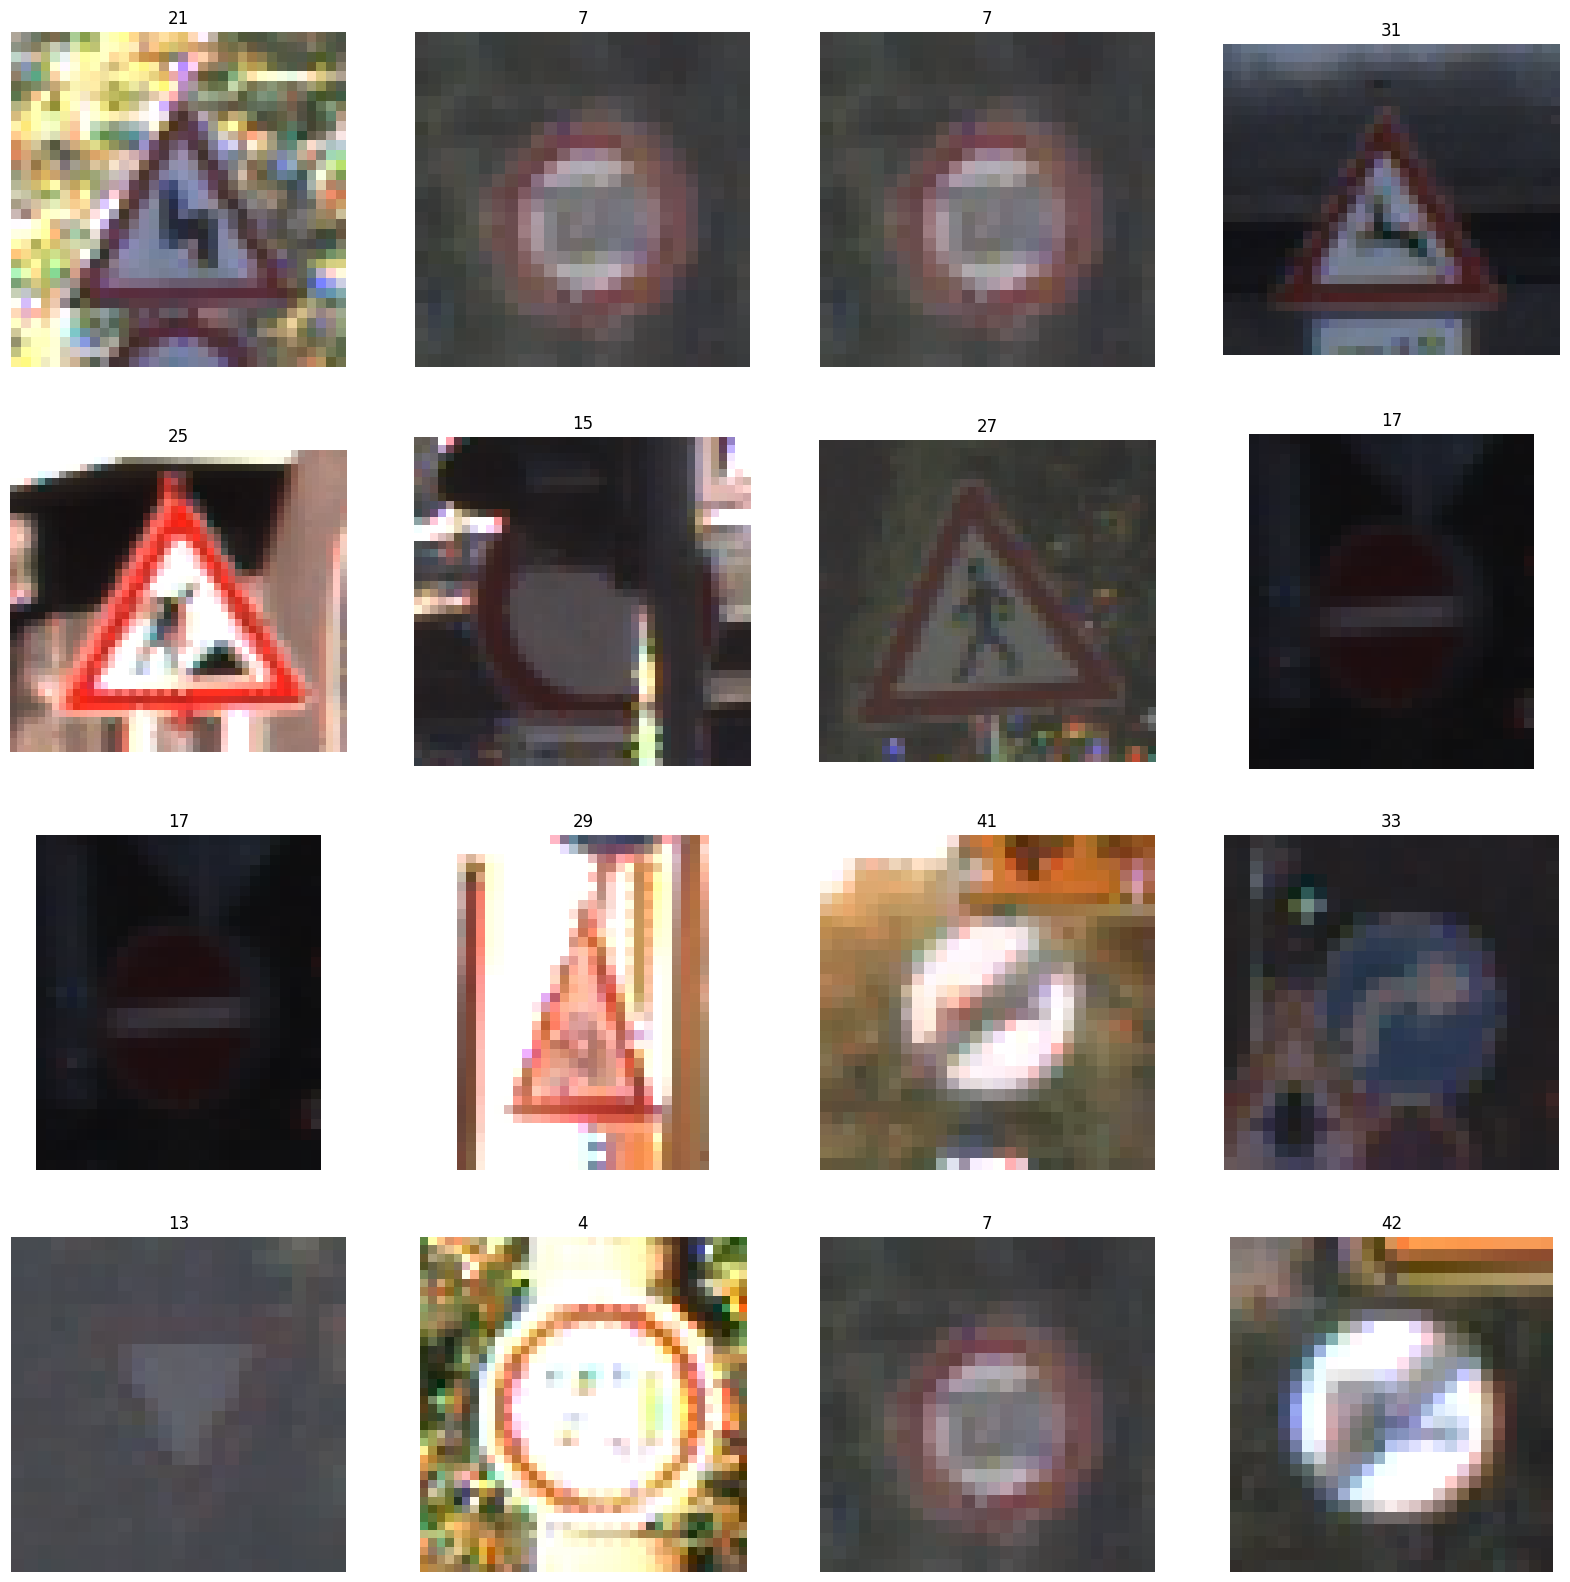

In [4]:
# get a 4x4 grid of 16 random images from the training set
TRAIN_PATH = 'dataset/Train/'
grid_size = 4
con = np.random.choice(classes, size=grid_size*grid_size)
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TRAIN_PATH + str(con[i*grid_size + j]) + '/' + os.listdir(TRAIN_PATH + str(con[i*grid_size + j]))[0])
		col.imshow(image)
		col.axis('off')
		col.set_title(con[i*grid_size + j])
plt.savefig('train_sample.png')
plt.show()


### Subset of images from the Test set

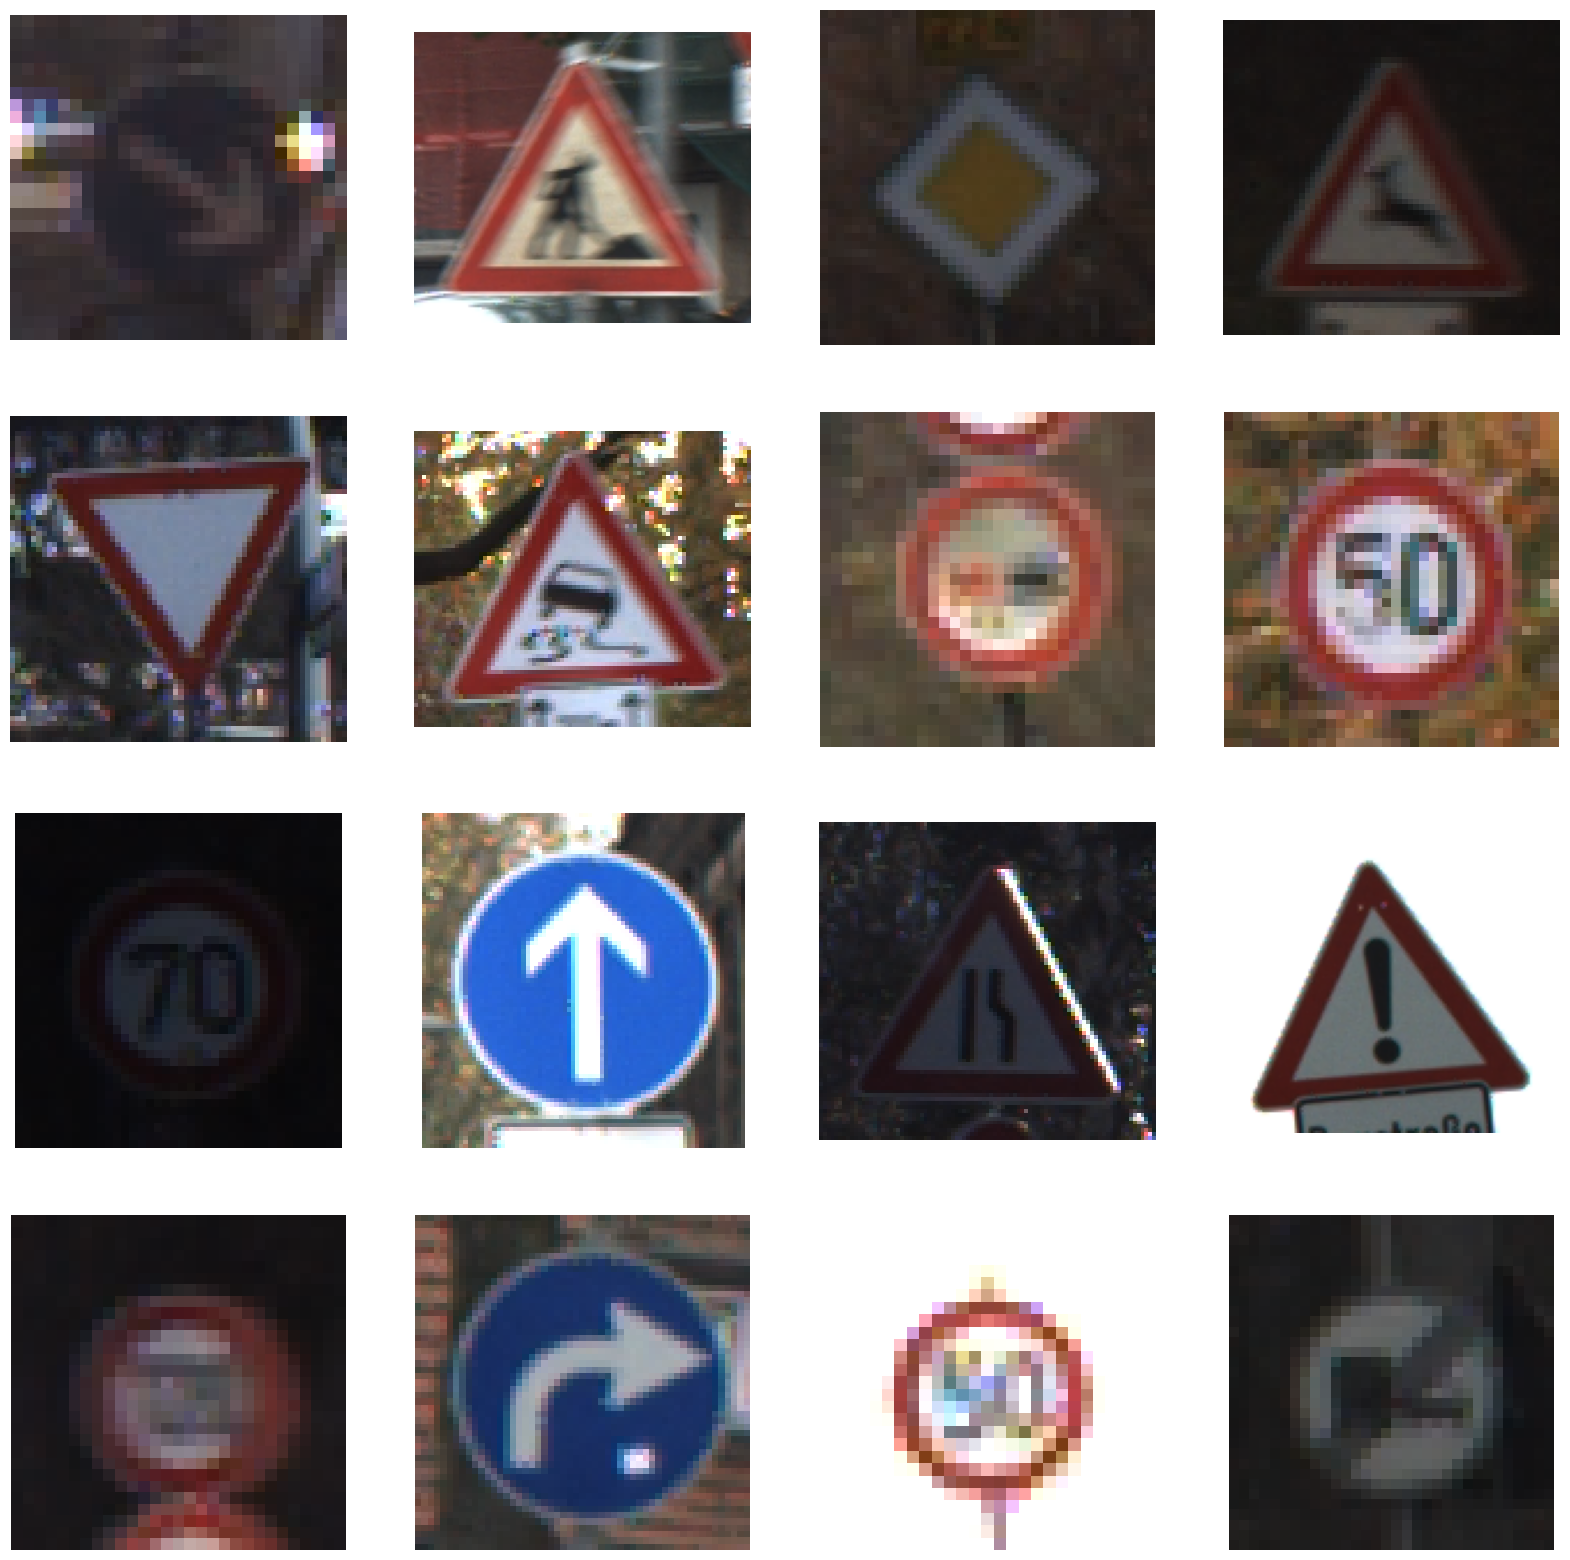

In [5]:
# get a 4x4 grid of 16 random images from the testing set
TEST_PATH = 'dataset/Test/'
grid_size = 4
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TEST_PATH + np.random.choice(os.listdir(TEST_PATH)))
		col.imshow(image)
		col.axis('off')
plt.savefig('test_sample.png')
plt.show()


### Collecting the Training Data

In [5]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + '/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = Image.open(path + '/' + img)
            # rgb
            image_fromarray = image.convert('RGB')
            # gray_scale
            #image_fromarray = image.convert('L')
            
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


### Shuffling the training data

In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

### Splitting the data into train and validation setSplitting the data into train and validation set

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## Create the model

In [11]:
import h5py
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
np.random.seed(42)

In [12]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [144]:
with h5py.File('traffic_classifier_kaggle_gray_scale_1channel.h5', 'r') as f:
    model = load_model(f)

In [120]:
model = keras.models.Sequential([ 
    # rgb   
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels), padding='same'),
    # gray scale
    #keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,1), padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
from keras_visualizer import visualizer

visualizer(model, file_format='png', view=True)

In [145]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

c:\Users\Gui\OneDrive\Universidade\3o Ano - UA\2o Semestre\Tópicos de Aprendizagem Automática\Projetos\Projeto 1\taa-projeto-1\venv\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### SVM

In [13]:
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern
import cv2
import pickle

In [135]:
# load the model from disk
clf = pickle.load(open('svc_model_rbf_c100_hog_ovo.sav', 'rb'))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)

def extract_hog_features(image, channel_axis=-1):
    if channel_axis not in (0, 1, 2, -1):
        raise ValueError("Invalid channel_axis value")

    if channel_axis == -1:
        channel_axis = 2

    features_per_channel = []
    for channel in range(image.shape[channel_axis]):
        channel_image = image[:, :, channel] if channel_axis == 2 else image[channel, :, :]
        features, _ = hog(channel_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        features_per_channel.append(features)

    return np.concatenate(features_per_channel)

def extract_lbp_features(image, radius=1, n_points=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # normalizar o histograma
    return hist

X_train_hog = np.array([extract_hog_features(image) for image in X_train])
X_test_hog = np.array([extract_hog_features(image) for image in X_test])

X_train_lbp = np.array([extract_lbp_features(image) for image in X_train])
X_test_lbp = np.array([extract_lbp_features(image) for image in X_test])

In [21]:
clf = SVC(kernel='poly', C=100, decision_function_shape='ovo')
history = clf.fit(X_train_hog, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      0.98      0.98       473
           2       0.98      0.98      0.98       424
           3       0.99      0.99      0.99       283
           4       0.99      0.99      0.99       373
           5       0.97      0.98      0.97       386
           6       1.00      1.00      1.00        88
           7       0.98      0.98      0.98       263
           8       0.99      0.97      0.98       313
           9       1.00      0.99      1.00       308
          10       0.99      1.00      1.00       395
          11       0.99      1.00      0.99       278
          12       1.00      1.00      1.00       419
          13       1.00      1.00      1.00       423
          14       1.00      1.00      1.00       164
          15       1.00      1.00      1.00       127
          16       1.00      1.00      1.00        88
          17       1.00    

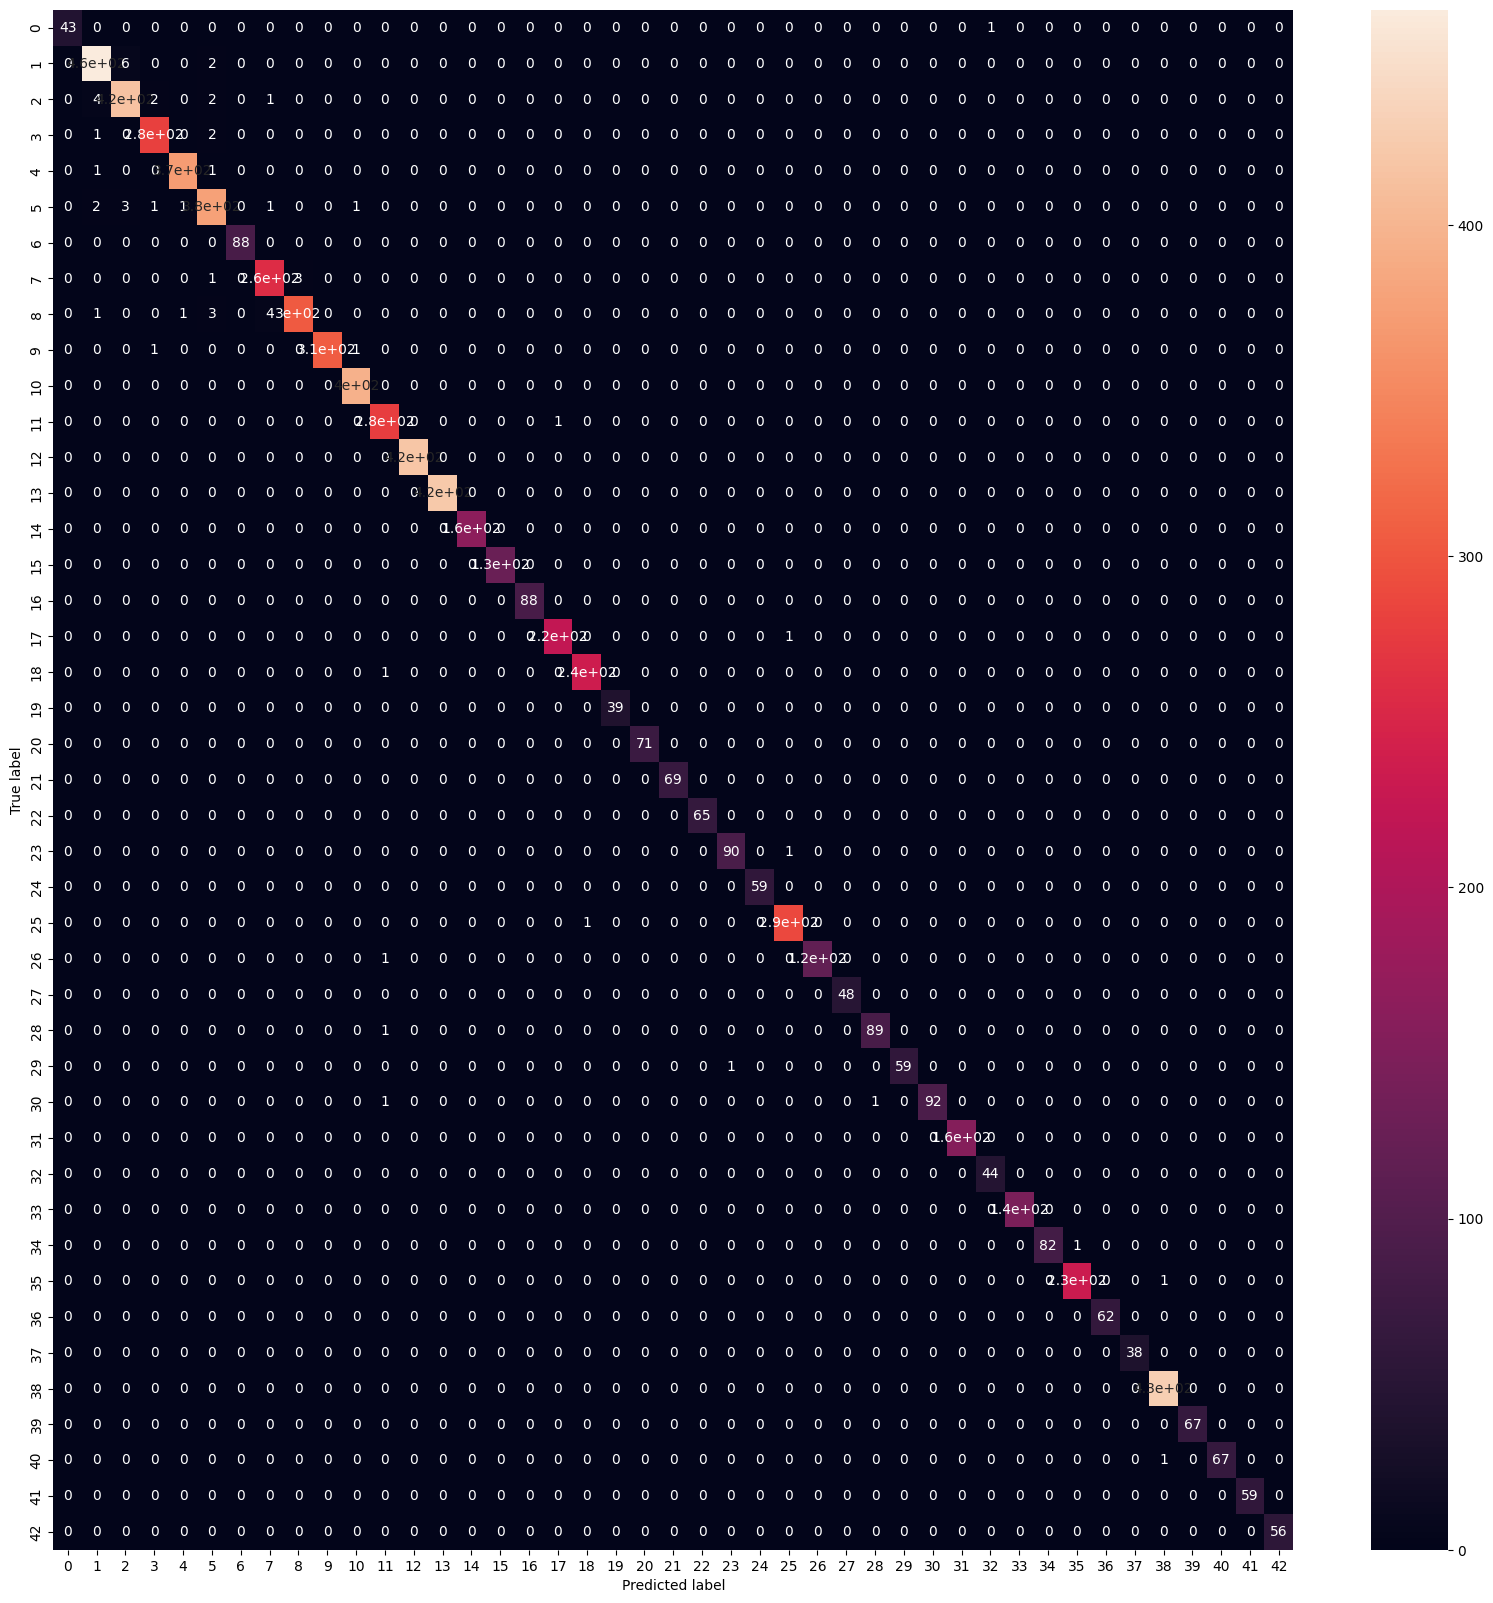

In [136]:
y_pred = clf.predict(X_test_hog)
cf = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_matrix.png')
classes = [str(x) for x in sorted(np.unique(image_labels))]
print(classification_report(y_test, y_pred, target_names=classes))

pred = y_pred
labels = y_test

In [139]:
filename = 'svc_model_rbf_c100_hog_ovo.sav'
pickle.dump(clf, open(filename, 'wb'))

### K fold CV

In [37]:
X = image_data
y = image_labels
k = 3

X_split1 = X[:int((1/k)*X.shape[0])]
y_split1 = y[:int((1/k)*y.shape[0])]
y_split1 = keras.utils.to_categorical(y_split1, NUM_CATEGORIES)

X_split2 = X[int((1/k)*X.shape[0]):int((2/k)*X.shape[0])]
y_split2 = y[int((1/k)*y.shape[0]):int((2/k)*y.shape[0])]
y_split2 = keras.utils.to_categorical(y_split2, NUM_CATEGORIES)

X_split3 = X[int((2/k)*X.shape[0]):]
y_split3 = y[int((2/k)*y.shape[0]):]
y_split3 = keras.utils.to_categorical(y_split3, NUM_CATEGORIES)

names = ['traffic_classifier_kaggle_rgb_split1.h5', 'traffic_classifier_kaggle_rgb_split2.h5', 'traffic_classifier_kaggle_rgb_split3.h5']
itr = iter(names)

for i in range(k):
	if i == 0:
		X_train = np.concatenate((X_split2, X_split3), axis=0)
		y_train = np.concatenate((y_split2, y_split3), axis=0)
		X_test = X_split1
		y_test = y_split1
	elif i == 1:
		X_train = np.concatenate((X_split1, X_split3), axis=0)
		y_train = np.concatenate((y_split1, y_split3), axis=0)
		X_test = X_split2
		y_test = y_split2
	elif i == 2:
		X_train = np.concatenate((X_split1, X_split2), axis=0)
		y_train = np.concatenate((y_split1, y_split2), axis=0)
		X_test = X_split3
		y_test = y_split3
	
	history = model.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=epochs)
	model.save(next(itr))


Epoch 1/30
817/817 [==============================] - 88s 108ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 14.2186 - val_accuracy: 0.0956
Epoch 2/30
817/817 [==============================] - 85s 104ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 15.5467 - val_accuracy: 0.0968
Epoch 3/30
817/817 [==============================] - 85s 104ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 15.6565 - val_accuracy: 0.0953
Epoch 4/30
817/817 [==============================] - 86s 105ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 15.5920 - val_accuracy: 0.0963
Epoch 5/30
817/817 [==============================] - 84s 103ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 17.0341 - val_accuracy: 0.0966
Epoch 6/30
817/817 [==============================] - 82s 100ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 17.0532 - val_accuracy: 0.0971
Epoch 7/30
817/817 [==============================] - 83s 101ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 16.6701 -

### Training the model

In [122]:
# gray scale
#X_train = np.expand_dims(X_train, axis=-1)
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 106s 122ms/step - loss: 1.0582 - accuracy: 0.7204 - val_loss: 0.1138 - val_accuracy: 0.9687
Epoch 2/30
858/858 [==============================] - 103s 120ms/step - loss: 0.1390 - accuracy: 0.9581 - val_loss: 0.0256 - val_accuracy: 0.9928
Epoch 3/30
858/858 [==============================] - 104s 121ms/step - loss: 0.0858 - accuracy: 0.9739 - val_loss: 0.0195 - val_accuracy: 0.9941
Epoch 4/30
858/858 [==============================] - 103s 120ms/step - loss: 0.0684 - accuracy: 0.9793 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 5/30
858/858 [==============================] - 103s 120ms/step - loss: 0.0509 - accuracy: 0.9840 - val_loss: 0.0155 - val_accuracy: 0.9955
Epoch 6/30
858/858 [==============================] - 103s 120ms/step - loss: 0.0476 - accuracy: 0.9847 - val_loss: 0.0106 - val_accuracy: 0.9966
Epoch 7/30
858/858 [==============================] - 80s 94ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 0.0109 - v

### Evaluating the model

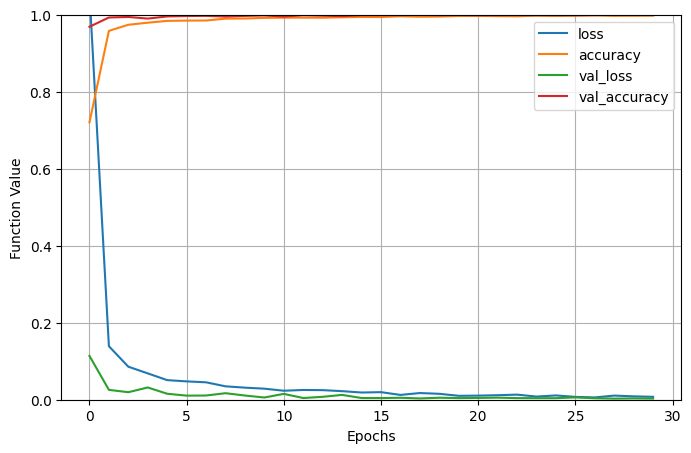

In [146]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Function Value')
plt.savefig('train_val_loss.png')
plt.show()

### Loading the test data and running the predictions

In [148]:
test = pd.read_csv('dataset/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = Image.open('dataset/' + img)
        # rgb
        #image_fromarray = image.convert('RGB')
        # grayscale
        image_fromarray = image.convert('L')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test).argmax(axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 8s 19ms/step
Test Data accuracy:  98.66983372921615


### Visualizing the confusion matrix

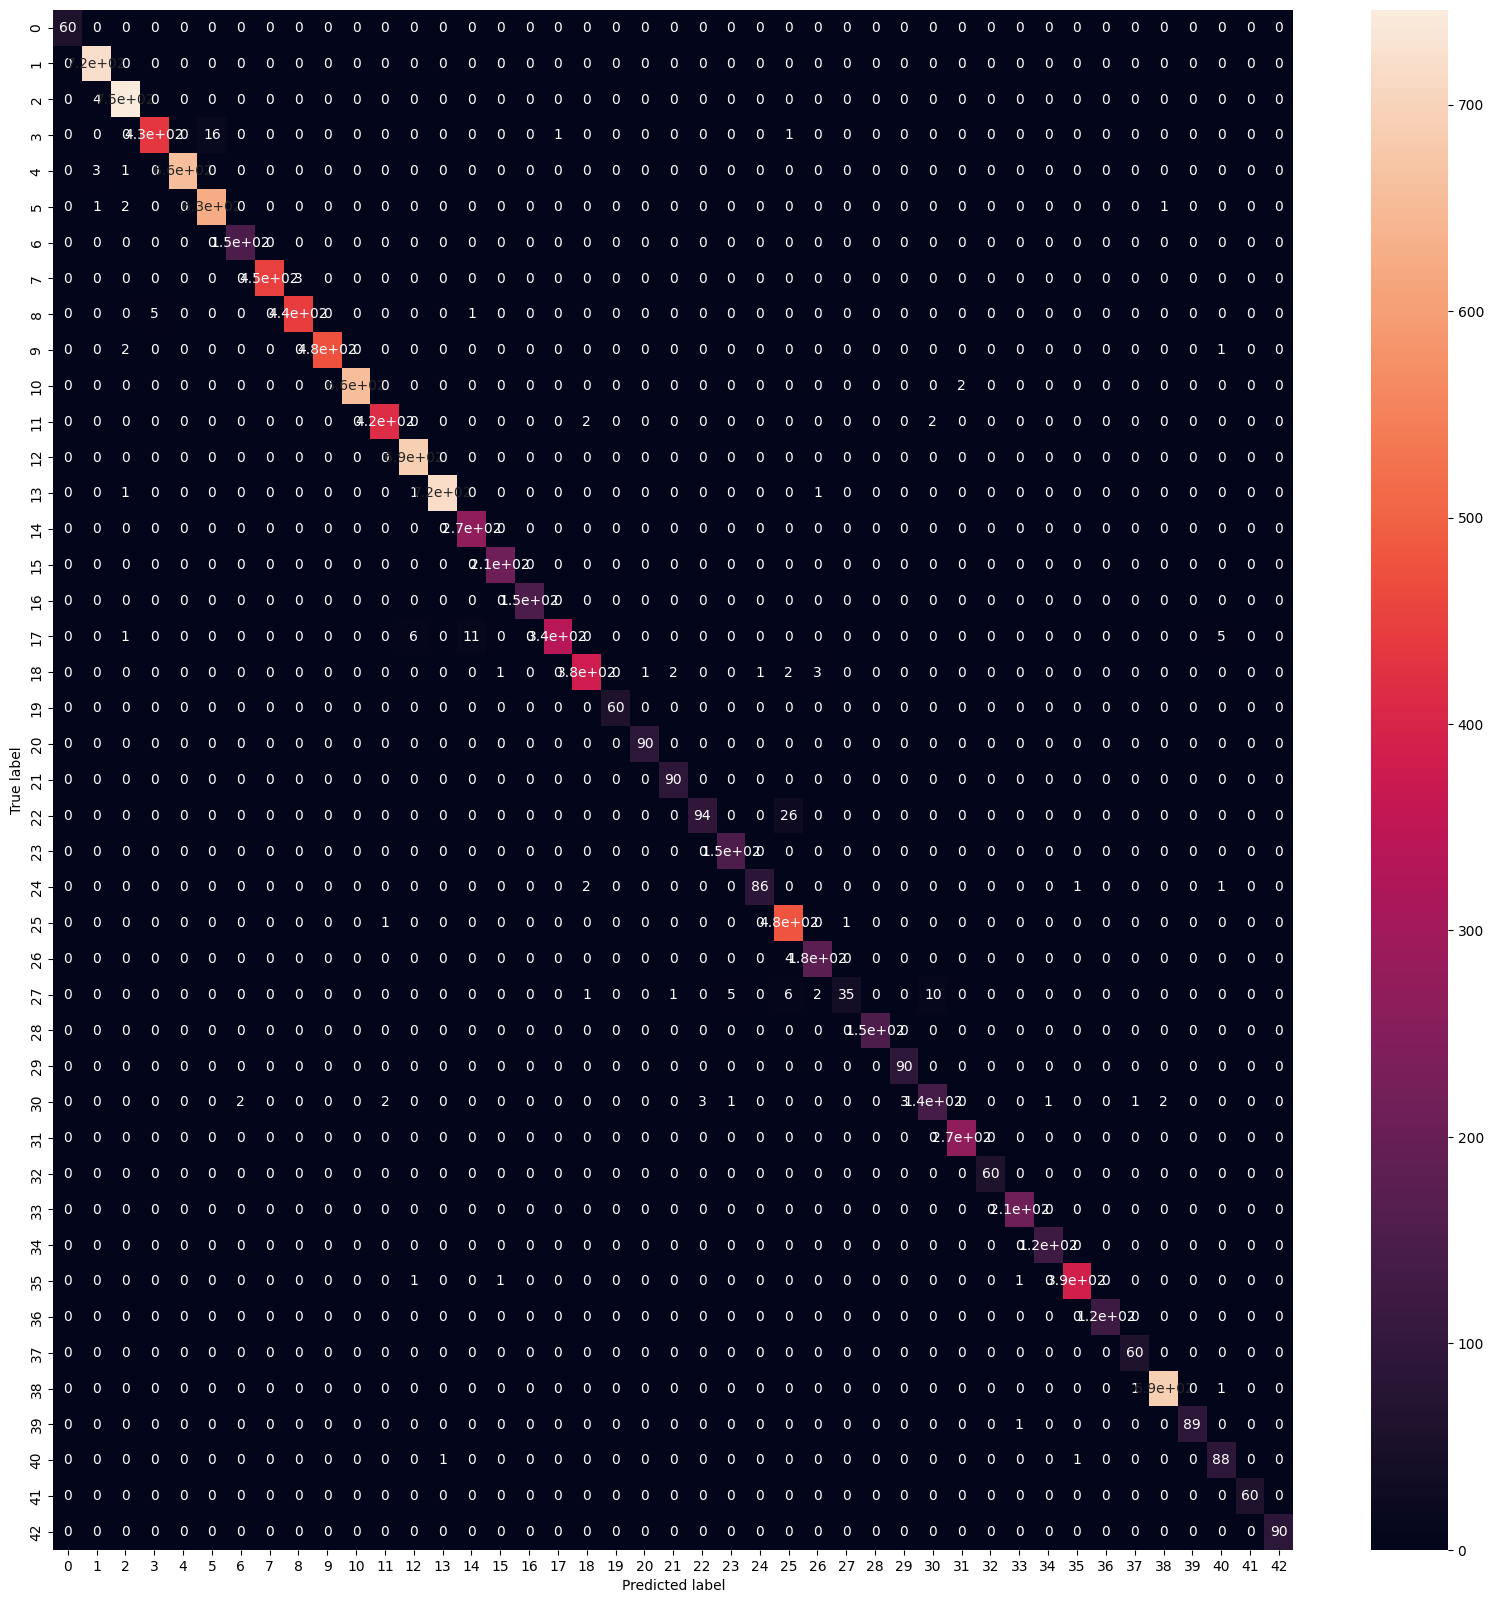

In [150]:
cf = confusion_matrix(labels, pred)
# plot confusion matrix heatmap and save it
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_matrix.png')

### Accuracy of the model per class

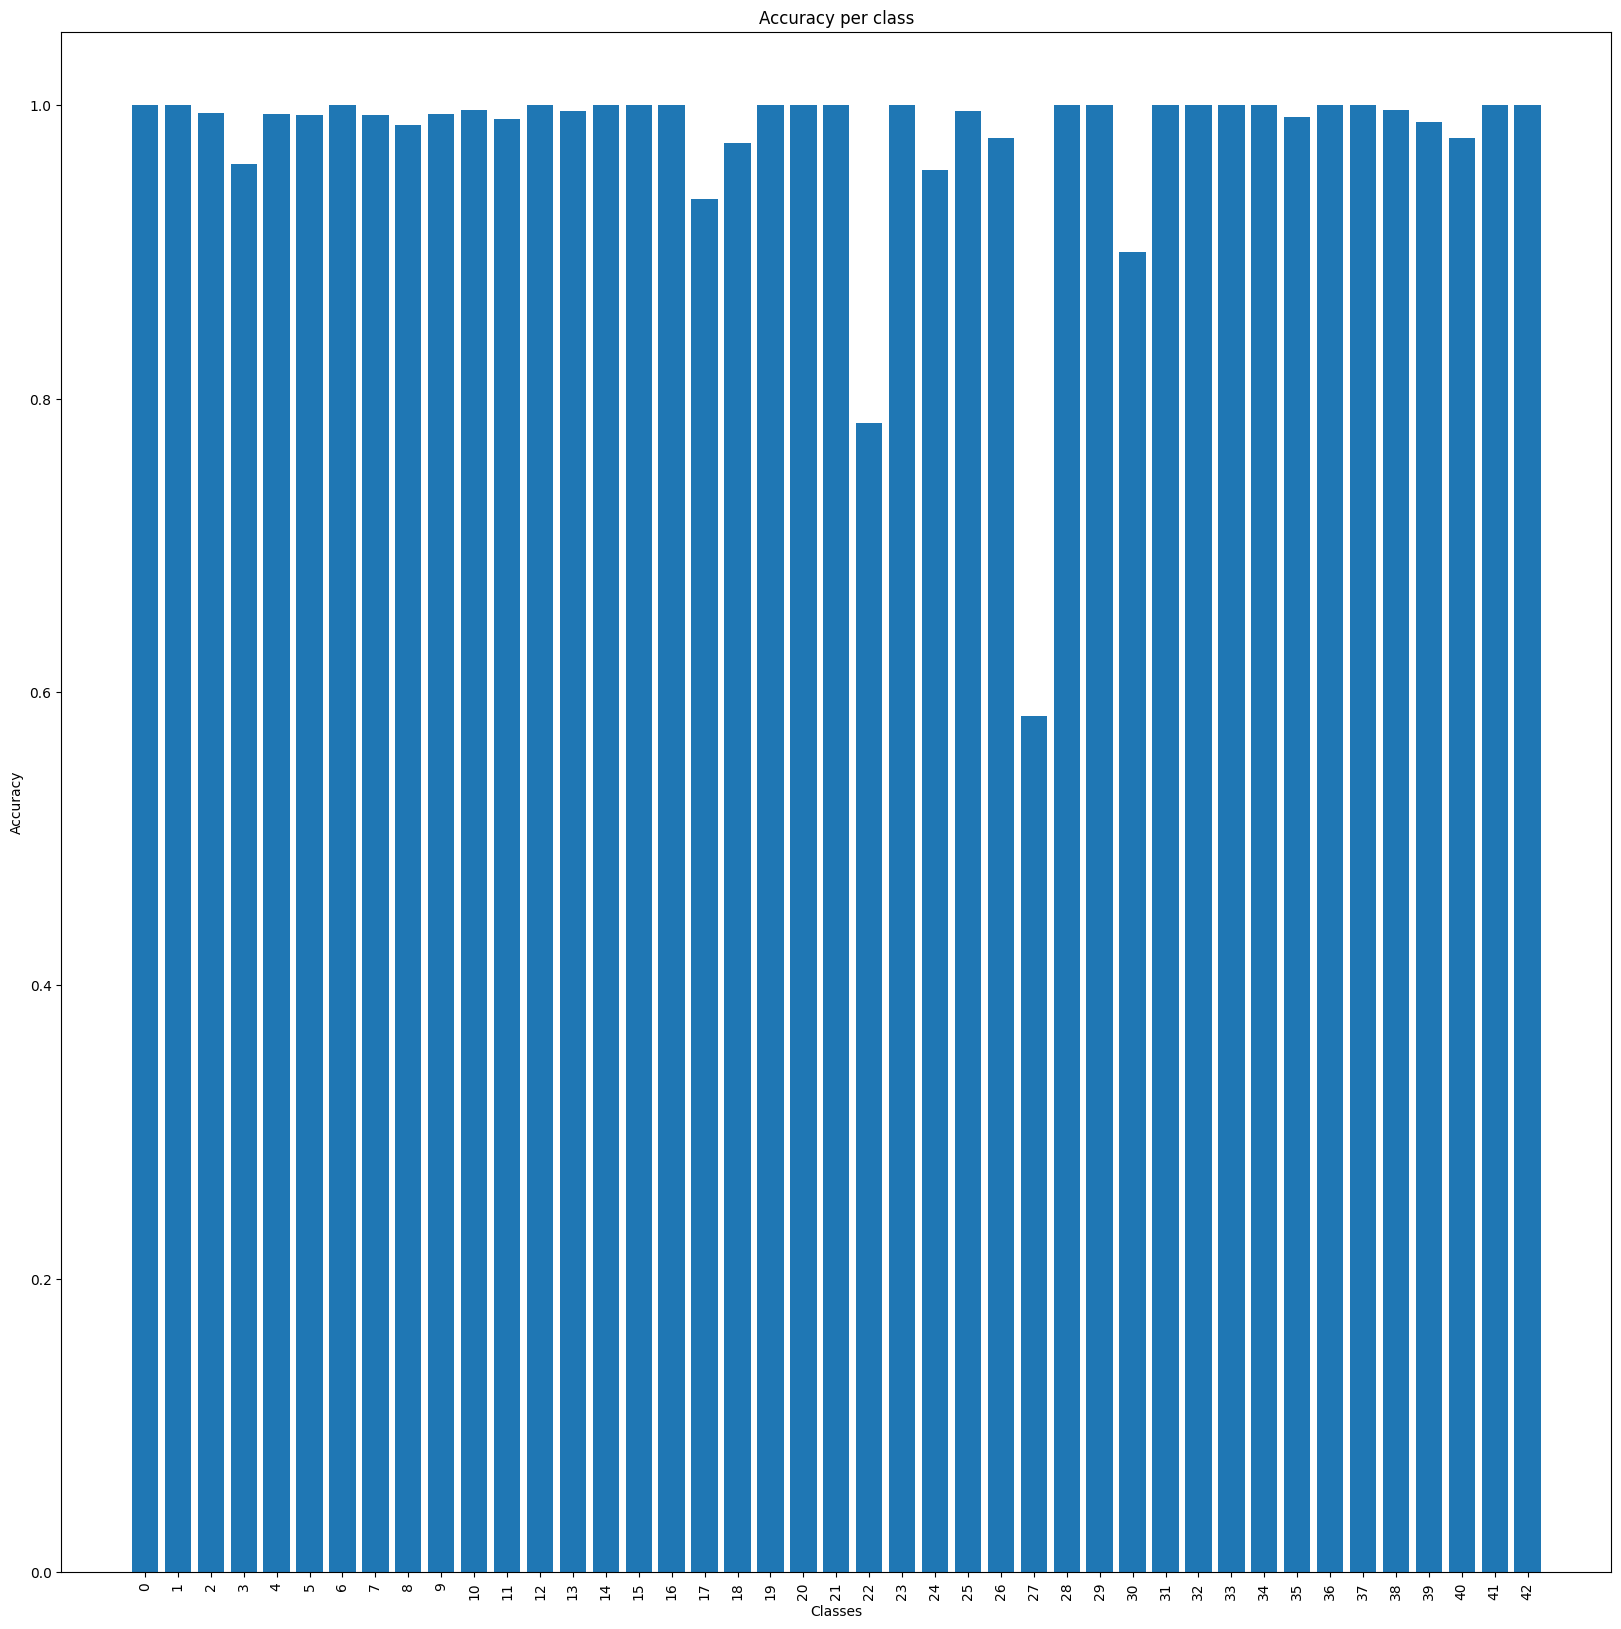

In [152]:
plt.figure(figsize=(20, 20))
plt.bar(classes, cf.diagonal()/cf.sum(axis=1))
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy per class')
plt.savefig('accuracy_per_class.png')
plt.show()

### Classification report

In [127]:
print(classification_report(labels, pred))

model.save("svc_model_rbf_c100_hog_ovo.sav")

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.99      1.00      0.99       720
           2       1.00      0.99      0.99       750
           3       0.96      0.97      0.96       450
           4       1.00      0.99      0.99       660
           5       0.98      0.99      0.99       630
           6       1.00      0.91      0.95       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      0.99       450
           9       1.00      0.98      0.99       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.98      1.00      0.99       150
          17       1.00    

### Predictions on Test Data

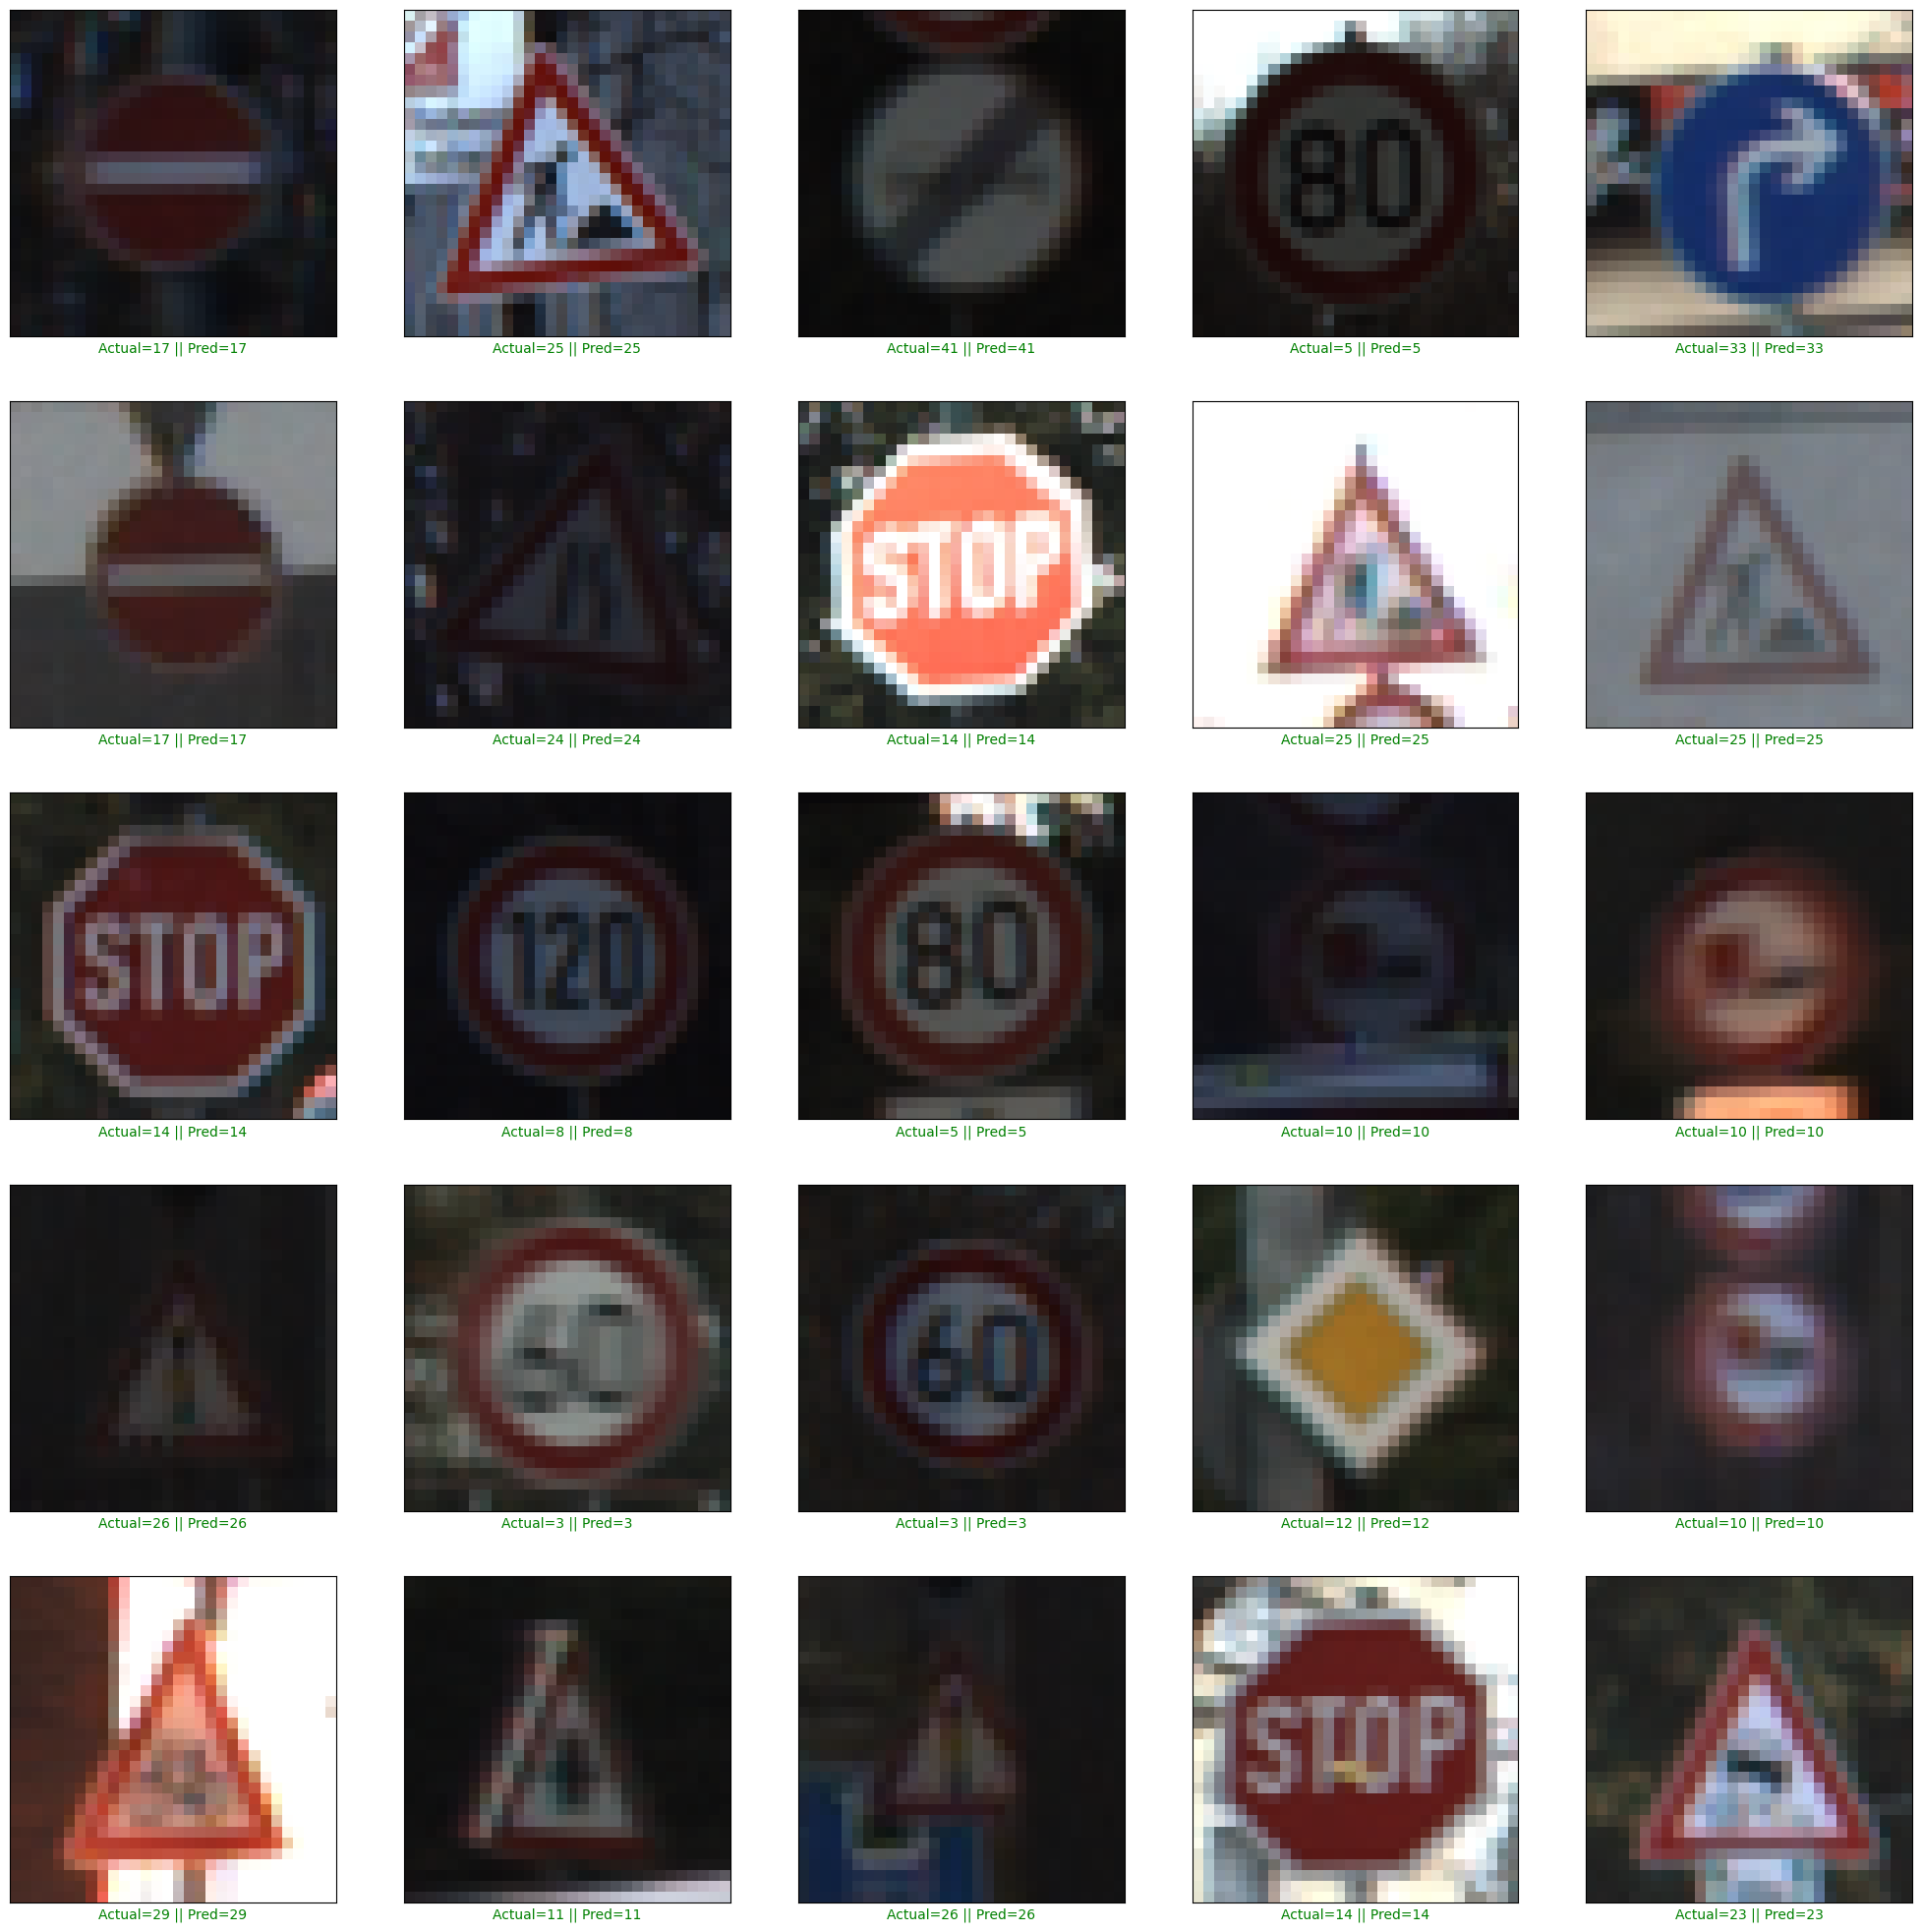

In [138]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()